# Notebook: Retrieval Augmented Generation (RAG) for Question Answering
---

Part of the [Masterclass: Large Language Models for Data Science](https://github.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science)
![](https://raw.githubusercontent.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science/refs/heads/main/slides/day_1/figures/pair-programming-with-llms.webp)
by Alex van Vorstenbosch
---

Check out the prompting cheatsheet for prompt inspiration: **Cheatsheet.pdf**!\
It can be found in the course material under **./slides/**.

It contains some example prompts and inspiration for all kinds of prompting tasks. Read it before starting on the assingments below.

If you want some more information about google colab and the different LLM models you can use, check out the **[general colab notebook](https://colab.research.google.com/drive/1LnsvqzL8BjO3m52siYJpakS-uR64B9pI?usp=sharing)**


# Context based question answering

In this notebook we will build a system that can answer question based on context retreived from your corpus of documents

This is where we bring it all together.
The past days we've learned about:

-   Large Language Models
-   Their strengths and weaknesses
-   Embeddings
-   Prompting
-   NLP

We will bring this all together in this supercharged tutorial/exercise set.

# Search + Generation

Large Language Models have a vast amount of internal knowledge. This internal knowledge is known as parametric knowledge.
This constitutes the general linguistic knowledge these models have, as well as the knowledge they have about the world in general.
However, you already know that this parametric knowledge is far from flawless.
These models tend to hallucinate more, the more detailed your requests become. Also, these models have no reference of what is true and what is not.
Truth and factualness is fundamentally not a core component in the training of these models, they just don't know.   
Furthermore, when using thse models you may have questions about:

-   Recent events
-   Proprietary documents
-   Private documents

Per definition these were not included in the training data.
In this case, we need to feed the model with our own knowledge base such that it may have the ability to answer our questions.
This works wonderfully because we can make use of the strong reasoning capabilities these models display on tokens that are directly accesible in memory (their context window).
You may liken this to an open book exam: Long term memory is flawed (also in humans) but by providing the model with direct reference texts we can supercharge the question answering capabilities, while allowing ourselves to make the exam (our questions) more specific and more difficult to answer.

# Dataset

For this assignment we will be working with a Wikipedia dataset that covers the category: ["Natural Language Processing"](https://en.wikipedia.org/wiki/Category:Natural_language_processing).
From this Wikipedia category a grand total of 964 articles have been extracted and parsed into plain-text.
The sections per page were filtered such that we should have retained only the most informative sections per article.
This means we filtered out the following sections:

-   See also
-   References
-   External links
-   Further reading
-   Footnotes
-   Bibliography
-   Sources
-   Citations
-   etc.

This left us with 4856 usable sections spread across 964 wikipedia pages.
These sections were also slightly cleaned by removing whitespaces and Wikipedia specific markup elements from their articles.

Each article was processed in so-called chunks of roughly 1600 tokens.
These chunks are what will become our searchable and retrievable elements.
If possible, chunks are made to be a single section of an article.
In some cases, this was not possible and a single section is split into multiple chunks.
For each chunk an corresponding embedding is generating using the API.
we can compare the embeddings of our chunks, looking for the embedding or the embeddings that most closely resemble our question.
Using this we can select the chunks that will be shared with our LLM during inference as the context that might answer our question.
Of course, it might also be that there are no chunks that are relevant to our question.

This data set can be found under: `./data/WIKIPEDIA_natural_language_processing.csv`.


# 1. Setup

First we will need to install the necessary python packages.
Luckily for us, google colab comes with most of the libraries and requiered cuda software already pre-installed.

## 1.1 Runtime
---

We will want to use a GPU to run the examples in this notebook. In Google Colab, go to the menu bar:


**Menu bar > Runtime > Change runtime type > T4 GPU**

---

## 1.2 Install packages
Run the cell below to install `llama-cpp-python` which allows fast inference on GPU and CPU with GGUF quantized models.



In [ ]:
# %% capture
!pip install --no-cache-dir llama-cpp-python==0.3.4 --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu122
!pip install adjustText
!pip install umap-learn
!pip install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu122


In [ ]:
import pandas as pd
from IPython.display import display
import json
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
)
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from umap import UMAP
import re
from fuzzywuzzy import fuzz
from llama_cpp.llama import Llama

# Matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

## 1.4 Load helper functions from github

In the repo I have included 2 helper functions for talking to LLMs:

1. generate_response\
   Generate a response given a set of chat messages, with optional streaming behavior.

2. interactive_chat\
   Allows the user to engage in an interactive chat session with the model (streaming by default).


In [ ]:
!curl -o helper_functions.py https://raw.githubusercontent.com/avvorstenbosch/Masterclass-LLMs-for-Data-Science/refs/heads/course_2025/exercises/day_1/helper_functions/helper_functions.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7910  100  7910    0     0  25213      0 --:--:-- --:--:-- --:--:-- 25271


In [ ]:
from helper_functions import *


# Embedding model
We will generate text-embeddings (just like the ones used inside LLMs) using [intfloat/multilingual-e5-large-instruct](https://huggingface.co/intfloat/multilingual-e5-large-instruct). This is a high quality embedding model, among one of the best model for retrieval embeddings available [Click here for a leaderboard with many benchmarks](https://huggingface.co/spaces/mteb/leaderboard).

These embeddings are usefull for tasks such as:

- Semantic Search
- Semantic Clustering
- Recommender Systems
- Anomaly Detection
- Classification (where text strings are classified by their most similar label)

The maximum amount of tokens that can be embedded in a single `multilingual-e5-large-instruct` embedding is 512. Anything longer is truncated.

Use the model to generate an embedding for a string of choice:

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
embedding_model = SentenceTransformer("intfloat/multilingual-e5-large-instruct")

In [ ]:
embedding = embeddings = embedding_model.encode("I am learning about large language models")

Compare the embedding to 3 random sentences below, which one is most similair to your sentence?

In [ ]:
sentences = [
    "The weather is lovely today, the sun is shining and the sky is blue.",
    "Studying lineair algebra is not always easy, but it is very usefull.",
    "Not too long ago, the Toyota Prius was the best-known hybrid vehicle on the market."
]
embeddings = embedding_model.encode(sentences)

similarities = embedding_model.similarity(embedding, embeddings)
similarities

tensor([[0.7016, 0.8181, 0.7561]])

Notice that these similarity scores are distributed between 0.7 and 1, regardless of what the inputs are. This is an artifact from the training process for these embeddings models. this will be discussed some more later

## A question the LLM cannot answer

During the Masterclass we talked about the famous Lawsuit where lawyers got into trouble because they used ChatGPT.
They cited precedents that were hallucinated by ChatGPT. This event took place in May 2023.
Our LLM is not aware of this precise event, so it cannot give a detailed answer to this question.
Let us give it a try. Write a query asking ChatGPT what it knows about this case.

-   Don't make your user prompt too short, as this will be detrimental to the content retrieval later on. Use at least 3 sentences.
-   You don't have to supply any specifics, but paint the general picture of the story.
-   Ask ChatGPT what ended up being the consequences for the lawyers in this court case.
-   This is the user prompt we will use throughout this notebook, you will not change it after this point.
-   **Instruct the LLM to only answer if it knows the answer. Otherwise is should reply with: "I do not know the answer to this question"**

In [ ]:
# ## Uncomment and run this cell if you need to clear the GPU memory!
# import gc
# import torch
# del llm

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# Load you llm model
llm = Llama.from_pretrained(
    # Huggingface repo name
    repo_id="bartowski/Meta-Llama-3.1-8B-Instruct-GGUF",
    # select the quant file within the repo you want '*' is a wildcard selector
    filename="*Q6_K.gguf",
    n_gpu_layers=-1,
    n_ctx=16384, # this is 25 A4 pages of context window!
    verbose=False,
    logits_all=True
)

In [ ]:
# Generate a classification
system_prompt = """
You are a helpfull assistant. If you do not know the answer, only reply with 'I do not know the answer to this question'
"""

user_prompt = """
Tell me who the lawyer was that got into trouble because they used ChatGPT cited precedents that were hallucinated by ChatGPT. What was their name and what was the penalty they were given?
"""

messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": user_prompt}
]
response_generator = generate_response(llm, messages, stream=True, max_tokens=1024, temperature=0)
for token in response_generator:
    print(token, end='', flush=True)

I do not know the answer to this question.

As you can see, the LLM does not know of what case we speak.
We can be happy about 1 thing:

- It told us that it has no knowledge of these events, and did not make up an answer instead.

We are going to prove in the next few sections, that given the right technique, we can get the LLM to tells us about this unknown event anyways.

## Retrieve the data, what does it look like?

Load the data set and explore a little, what does the data look like?

In [ ]:
# load the dataset
data = pd.read_csv("./data/WIKIPEDIA_natural_language_processing.csv", sep=",")

# We must parse the dataset into the right format for later.
# Right now the embeddings have been loaded as strings,  convert them to vectors straight away.
# Don't forget to remove the [ and ] from the string. If you get stuck, consider asking your LLM (or Gemini) for help
def string_to_array(vector_string):
       # Remove brackets and split the string into elements
       elements = vector_string[1:-1].split(', ')
       # Convert elements to floats and create a numpy array
       return np.array(list(map(float, elements)))

data["embedding"] = data['embedding'].apply(string_to_array)

In [ ]:
data.sample(5)

,page,text,embedding
1360,Tree transducer,Tree transducer\n\nIn theoretical computer sci...,"[0.028373898938298225, 0.04209963604807854, -0..."
3822,Sentiment analysis,Sentiment analysis\n\n== Evaluation ==\n\nThe ...,"[0.020688051357865334, -0.012097530998289585, ..."
3980,Xiaoice,Xiaoice\n\n== Application ==\n\n=== Kid Audio-...,"[0.027478057891130447, 0.0016762269660830498, ..."
4582,Arabic machine translation,Arabic machine translation\n\n== Approaches fo...,"[0.020790405571460724, 0.009995806030929089, -..."
1253,Automatic number-plate recognition,Automatic number-plate recognition\n\n== Usage...,"[0.0389321893453598, 0.0015152441337704659, -0..."


# Playing with embeddings

In order to find the correct contextual information, we will need to embed our `user_prompt`, as it will be the key to our search algorithm.
Go ahead and create an embedding of your user prompt, use the `generate_query` function to generate a query in the format that `intfloat/multilingual-e5-large-instruct` expects. Next use the `embedding_model` to create an embedding

In [ ]:
query = generate_query(user_prompt)
prompt_embedding = embedding_model.encode(query)

What are the number of dimensions of the embedding?
and what is the length of this vector? This is calculated using the [Euclidean norm](https://mathworld.wolfram.com/L2-Norm.html)
Round the result to 3 decimal places.

In [ ]:
print(f"The vector has {prompt_embedding.shape} dimensions and a length of {np.sqrt(prompt_embedding @ prompt_embedding):.3f}")

The vector has (1024,) dimensions and a length of 1.000


With such a high number of dimensions, there is a lot of information about prompt that is encoded in this vector.
These embeddings have been normalized. This means they have unit length.
Because of this, these embeddings only have 1 fundamental quality that is informative to us and that is the pointing direction of the vector.
This direction contains all the information the model has about the meaning of the embedded text:

- Chunks with more similar meaning have more similar embeddings,
- Chunks with more different meaning have more different embeddings.

Play around with this property. Write the same sentence twice, worded slightly differently, how do these embeddings compare? You can use `embedding_model.similarity` do this.

In [ ]:
sentence_1 = "I am enjoying learning about large language models today"
sentence_2 = "I am having a good time following a workshop on large language models at this moment"
embedding_model.similarity(embedding_model.encode(sentence_1), embedding_model.encode(sentence_2))

tensor([[0.9559]])

Now write a third sentence with the same topic of the first sentence, but with the opposite polarity for example. How does this embedding compare?

In [ ]:
sentence_3 = "I am not enjoying learning about large language models today"
print(
    embedding_model.similarity(embedding_model.encode(sentence_1), embedding_model.encode(sentence_3)),
    embedding_model.similarity(embedding_model.encode(sentence_2), embedding_model.encode(sentence_3))
)

tensor([[0.9461]]) tensor([[0.9135]])


Now write a fourth sentence that shares no similarities whatsover with the first sentence. How does this embedding compare?

In [ ]:
sentence_4 = "The frosting is the best part of the carrot-cake!"
print(
    embedding_model.similarity(embedding_model.encode(sentence_1), embedding_model.encode(sentence_4)),
    embedding_model.similarity(embedding_model.encode(sentence_2), embedding_model.encode(sentence_4)),
    embedding_model.similarity(embedding_model.encode(sentence_3), embedding_model.encode(sentence_4))
)

tensor([[0.7424]]) tensor([[0.7612]]) tensor([[0.7304]])


As you can see, even for topics that share no common subject the score does not go below ~ 0.7

## Visualising our embedding space

We can make some interesting visualizations from our embeddings. This will demonstrate that our embeddings capture a lot of semantic information about the texts that are embedded.
Here we will project our high-dimensional embeddings onto 2 dimensions using the `umap` algorithm.
These projections lose a lot of the original information, but allow us to plot our data.
`UMAP` is a dimensionality reduction algorithm that works well at preserving both global and local structure in the data.

Fill in the code in the cells below to achieve the following:

- For each page (article), calculate the average embedding. Don't forget to normalize the length after averaging.
- Calculate the reduced embedding form in 2 dimensions.
- Sample these reduced form embeddings for N pages.
- Plot the results, including page titles.

The projection steps have been performed for you in this cells below:

In [ ]:
# Get 1 average embedding per page
data_average = data.groupby("page").agg(
    {"embedding": lambda x: np.mean(np.vstack(x), axis=0)}
)
data_average["embedding"] = data_average["embedding"].apply(
    lambda x: x / np.linalg.norm(x, 2)
)

In [ ]:
# Calculate reduced embeddings
embedding_matrix = np.vstack(data_average['embedding'])
umap_model = UMAP()
umap_embeddings = umap_model.fit_transform(embedding_matrix)

# Perform UMAP dimensionality reduction
umap_model = UMAP()
umap_embeddings = umap_model.fit_transform(embedding_matrix)

# Add the UMAP embeddings to the data_average dataframe
data_average['x1'] = umap_embeddings[:, 0]
data_average['x2'] = umap_embeddings[:, 1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [ ]:
# Sample the reduced embeddings for N pages
np.random.seed(1234)
n_pages = 800
data_plot = data_average.drop(columns='embedding').sample(n=n_pages).reset_index()

Visualize the different Wikipedia articles using the code below.
It is best to play with the value for n_pages a bit, as well as the text size.
Open the figure in full screen.
Explain, what do you see?

In [ ]:
# Create an interactive scatter plot
fig = px.scatter(
    data_plot,
    x="x1",
    y="x2",
    color="page",        # Colors each point by its category
    text="page",         # Display the category as a text label on each point
    title="Interactive Scatter Plot of Pages",
    labels={
        "x1": "X Axis Label",
        "x2": "Y Axis Label",
        "page": "Category"
    },
    template="plotly_white"
)

# Update the traces to adjust marker and text appearance
fig.update_traces(
    marker=dict(size=10, opacity=0.6),
    textfont=dict(size=8, color='black'),
    textposition='top center',  # Places the text just above each marker
    selector=dict(mode='markers+text')  # Ensure both markers and text are updated
)

# Further update the layout for a more polished look
fig.update_layout(
    title=dict(
        text="Interactive Scatter Plot of Pages",
        x=0.5,  # Center the title
        xanchor='center',
        font=dict(size=24)
    ),
    legend_title_text="Categories",
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=""),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False, title=""),
    width=1600,  # Adjust width (default is often too wide)
    height=900  # Increase height for a taller view
)

fig.show()


## Performing similarity search using our embeddings - euclidean distance

Now we want to start comparing our embeddings to one another.
One might think of just calculating a regular distance metric like euclidean distance for our embeddings, after all our vectors represent a single point in space.
So we could just look to see which ones are the closest together.
However, in practice that will not work.
*Can you think of a reason why not?*

In [ ]:
# Because of the course of dimmensionality

## Performing similarity search using our embeddings - cosine distance

The easiest way to to compare our embeddings is through the metric called `cosine similarity`.
Because our vectors are already normalised, we can use take the dot-product (inner product) between 2 vectors to directly calculate the angle between them, this is the cosine distance.
You can calculate the cosine similarity by using `vector_1 @ vector_2`, or you can use `embedding_model.similarity`

Calculate the cosine similarity between our prompt_embedding and all embeddings in the dataset, store this value in the column `similarity score`.

In [ ]:
# Apply the function row-wise
calculate_similarity = lambda x: embedding_model.similarity(prompt_embedding.astype(np.float64), x.embedding).item()
data['similarity_score'] = data.apply(calculate_similarity, axis=1)

# Sort the DataFrame by similarity_score in descending order
data_similarity = data.sort_values(by='similarity_score', ascending=False)

Plot the distribution of similarity scores:

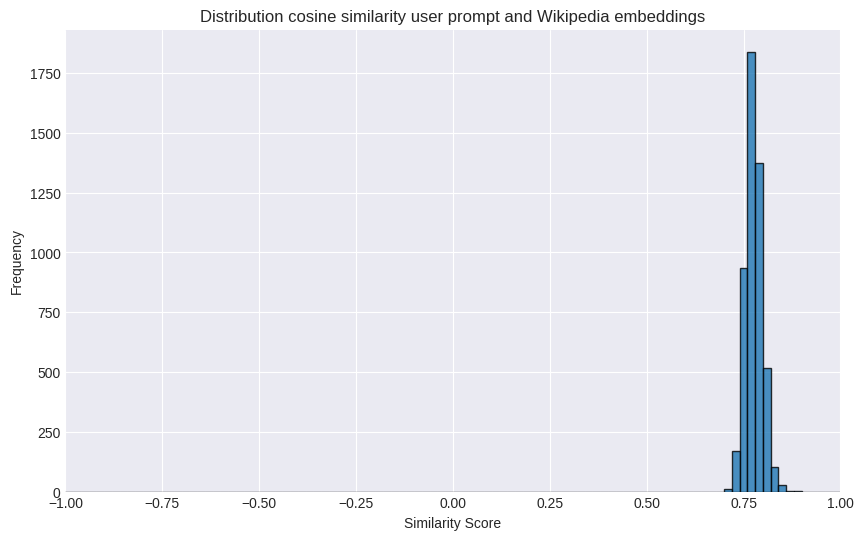

In [ ]:
# Create the histogram
bins = np.linspace(-1, 1, 101)
plt.figure(figsize=(10, 6))
plt.hist(data_similarity['similarity_score'], bins=bins, alpha=0.8, edgecolor='black')
plt.xlim(-1, 1)
plt.title("Distribution cosine similarity user prompt and Wikipedia embeddings")
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

It is somewhat suprising what you see in this plot. You'd expect there to be a very large range from -1 to 1:

- If vectors are the same it is 1
- If vectors are orthogonal it is 0
- If vectors are in opposite directions it is -1

but instead the values are concentrated around 0.7.
What this essentially means is that all our vectors share a big component in the same direction

To see what is going on, we will make another figure.
Make another plot showing the distribution of cosine similarities with respect to the user prompt, together with the following 3 input prompts:

-   label: "Deltaplan" - prompt:"The estuaries of the rivers Rhine, Meuse and Schelde have been subject to flooding over the centuries. After building the Afsluitdijk (1927 – 1932), the Dutch started studying the damming of the Rhine-Meuse Delta. Plans were developed to shorten the coastline and turn the delta into a group of freshwater coastal lakes. By shortening the coastline, fewer dikes would have to be reinforced. Due to indecision and the Second World War, little action was taken. In 1950 two small estuary mouths, the Brielse Gat near Brielle and the Botlek near Vlaardingen were dammed. After the North Sea flood of 1953, a Delta Works Commission was installed to research the causes and develop measures to prevent such disasters in future. They revised some of the old plans and came up with the 'Deltaplan'."
-   label: "Baking" - prompt:"What is the best recipe for baking a carrot cake? I prefer them with not too many spices. The icing should be made with cream cheese of course"
-   label: "Astronomy" - prompt:"A few years ago I remember seeing newspaper articles about astronomers imaging the black hole in our own milky way, how did they achieve this?"

Use these labels to add fill color to your histogram:

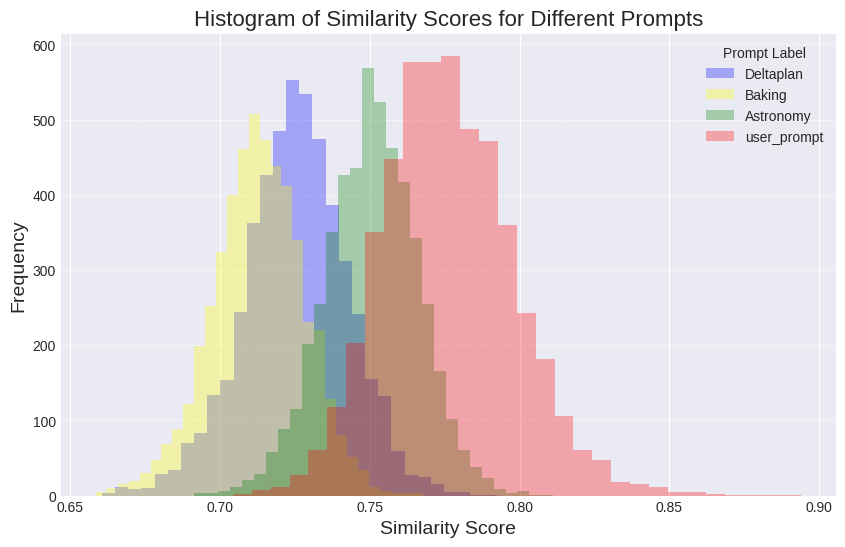

In [ ]:
results = []
prompts = [
  "The estuaries of the rivers Rhine, Meuse and Schelde have been subject to flooding over the centuries. After building the Afsluitdijk (1927 – 1932), the Dutch started studying the damming of the Rhine-Meuse Delta. Plans were developed to shorten the coastline and turn the delta into a group of freshwater coastal lakes. By shortening the coastline, fewer dikes would have to be reinforced. Due to indecision and the Second World War, little action was taken. In 1950 two small estuary mouths, the Brielse Gat near Brielle and the Botlek near Vlaardingen were dammed. After the North Sea flood of 1953, a Delta Works Commission was installed to research the causes and develop measures to prevent such disasters in future. They revised some of the old plans and came up with the 'Deltaplan'.",
  "What is the best recipe for baking a carrot cake? I prefer them with not too many spices. The icing should be made with cream cheese of course",
  "A few years ago I remember seeing newspaper articles about astronomers imaging the black hole in our own milky way, how did they achieve this?"
]

labels = [
  "Deltaplan",
  "Baking",
  "Astronomy"
]

# Add the embedding matrix to the results lists
for i, prompt in enumerate(prompts):
    embedding_tmp = embedding_model.encode(generate_query(prompt))
    calculate_similarity = lambda x: embedding_model.similarity(embedding_tmp.astype(np.float64), x.embedding).item()
    data['similarity_score'] = data.apply(calculate_similarity, axis=1)
    data_similarity_tmp = data.sort_values(by='similarity_score', ascending=False)
    data_similarity_tmp['label'] = labels[i]
    results.append(data_similarity_tmp)

data_similarity["label"] = "user_prompt"
results.append(data_similarity)

# Combine the dataframes with pd.concat
result = pd.concat(results, ignore_index=True)

# plot the histogram of the 4 prompts at the same time
# Set figure size
plt.figure(figsize=(10, 6))

# Define a list of colors for each histogram
colors = ['blue', 'yellow', 'green', 'red']

# Plot a histogram for each label
for i, label in enumerate(result['label'].unique()):
    subset = result[result['label'] == label]
    plt.hist(subset['similarity_score'], bins=30, alpha=0.3, color=colors[i], label=label)

# Customize plot aesthetics
plt.xlabel("Similarity Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Histogram of Similarity Scores for Different Prompts", fontsize=16)
plt.legend(title="Prompt Label")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

What do you see?

You can see the following:

- The embeddings of `intfloat/multilingual-e5-large-instruct` have a  small dynamic range.

- This in itself is not a big issue. We still see that the user prompt on AI got the highest similarity with the dataset, while the prompt on baking got the lowest similarity with the dataset.

- This does help demonstrate that in practice it is difficult to set a reasonable cut-off for cosine similarity as one can do with other embedding models

## Collect best matches

Retrieve the 3 values with the highest similarity_score with our original user prompt, and store them in a table called `context`.

In [ ]:
context = data_similarity.head(3).reset_index()

# Retrieval Augmented Generation

Now we have all the steps to perform retrieval augmented generation.
Let's get going!

## First try

We've kept the user_prompt from the beginning, which we will not touch.
Instead, change the system prompt to achieve the following:

- The 3 best matching context chunks from data_similarity should be passed to the model as context.
- It should only answer, if the context provides an answer.
- The answer should only be based on the context, nothing else.
- The answer should be as detailed as possible.
- As we are passing the best matches as additional context for the answer, it is custom to add these to the system prompt. In a typical chat interface the user doesn't see the system prompt, thus this step is not revealed to the user.

In [ ]:
def system_prompt(context):
  return f"""
You are an assistant who answers questions using only the provided context.
You have been provided with context information from 3 sources below. A user will ask you a question, only base your answer on the information provided in the sources.
If the question cannot be answered, say 'I do not know the answer to this question'.
Your answer should be as detailed as possible given this context.
Please insert enters to make the max line length ~20 words for formatting purposes.

###
{context.text[0]}
###

###
{context.text[1]}
###

###
{context.text[2]}
###
"""

messages = [
    {"role": "system", "content": system_prompt(context)},
    {"role": "user", "content": user_prompt}
]
response_generator = generate_response(llm, messages, stream=True, max_tokens=1024, temperature=0)
for token in response_generator:
    print(token, end='', flush=True)

The lawyer who got into trouble for using ChatGPT-cited precedents that were hallucinated by ChatGPT was Stephen Schwartz. 

He submitted six fake case precedents generated by ChatGPT in his brief to the Southern District of New York on 'Mata v. Avianca', a personal injury case against the airline Avianca.

As for the penalty, Stephen Schwartz and another lawyer were fined $5,000 by Judge P. Kevin Castel for bad faith conduct.

Yeah!
Now we are getting answers.
However, we are not quite there yet.
Now we have an answer, but how can we know it is true?
It could still be making this up.
For a single example we can of course fact-check the sources ourselves.
But automation is the name of the game: we need to find a better solution!

## Making responses (more) verifiable

Once again, we are going to pass text content to our system prompt.
This time, it will be very important that the model only answers using direct quotes from the context-chunks:

-   It should only answer in the format: (\`Wikipedia article: name\`): "quoted text"

-   It should only answer, if the context provides an answer.

-   Quotes should only be direct, no paraphrasing.

-   It is not allowed to use ellipses to shorten a quote.

-   The answer should be as detailed as possible.

In [ ]:
def system_prompt(context):
  return f"""
You are an assistant who answers questions using only cited quotes.
Please insert enters to make the max line length ~20 words for formatting purposes.
You have been provided with context information from 3 sources below. A user will ask you a question, only base your answer on the information provided in the sources. If the question cannot be answered, say so.
Your answer should be as detailed as possible given this context. Only provide quotes from the sources provided to answer the question.
Indicate the source of these quotes by referencing the source title in paranthesis before the quote. You are not allowed to shorten any quotes using ellipses.
Do not adjust the formatting or wording of these quotes, copy them verbatim.
The answer should be formatted like:

(`Wikipedia article: name`): \"quoted text\"


source 1 - 'Wikipedia article: {context.page[0]}'
###
{context.text[0]}
###

source 2 - 'Wikipedia article: {context.page[1]}'
###
{context.text[1]}
###

source 3 - 'Wikipedia article: {context.page[2]}'
###
{context.text[2]}
###
"""

messages = [
    {"role": "system", "content": system_prompt(context)},
    {"role": "user", "content": user_prompt}
]
response_generator = generate_response(llm, messages, stream=True, max_tokens=1024, temperature=0)
for token in response_generator:
    print(token, end='', flush=True)

(`Wikipedia article: Hallucination (artificial intelligence)`): "In May 2023, it was discovered Stephen Schwartz submitted six fake case precedents generated by ChatGPT in his brief to the Southern District of New York on Mata v. Avianca, a personal injury case against the airline Avianca."

(`Wikipedia article: Hallucination (artificial intelligence)`): "On June 23 P. Kevin Castel tossed the Mata case and issued a $5,000 fine to Schwartz and another lawyer for bad faith conduct, who continued to stand by the fictitious precedents despite his previous claims."

Hooray!
You can see that the model is mostly doing what we want.

It is quoting directly from the context documents we retrieved with our simple RAG setup.\
It is giving some extra reasoning around these quotes,
but that is not an issue.

## Is our LLM quoting correctly?

Now we want to verify the information provided by our LLM.
We can use simple `regular expressions` to extract the sources from the response, as well as the quotes.
We can check if these quotes are indeed present in the context we provided.

In [ ]:
response = generate_response(llm, messages, max_tokens=1024, temperature=0)

In [ ]:
# Regular Expression to capture the article name as it is in your context-table
regex_articles = r"Wikipedia article: ([^`]+)"

# Using re.findall to extract all matches
article_names = re.findall(regex_articles, response)

In [ ]:
article_names

['Hallucination (artificial intelligence)',
 'Hallucination (artificial intelligence)']

In [ ]:
# Regular Expression to capture the content of the quote.
regex_quotes = "\"([^\"]+)\""

# Using str_match_all to extract all matches
quotes = re.findall(regex_quotes, response)

In [ ]:
quotes

['In May 2023, it was discovered Stephen Schwartz submitted six fake case precedents generated by ChatGPT in his brief to the Southern District of New York on Mata v. Avianca, a personal injury case against the airline Avianca.',
 'On June 23 P. Kevin Castel tossed the Mata case and issued a $5,000 fine to Schwartz and another lawyer for bad faith conduct, who continued to stand by the fictitious precedents despite his previous claims.']

Now the question is, how do we check if these quotes are present in the text.
We cannot use: `A in B` syntax.
If our model changes a single character; it won't work to do literal matching.
Instead, we will use a clever solution called Levenshtein distance.
Please look up what Levenshtein distance is, what does it calculate?

In [ ]:
# It calculates the minimal number of edits (insertions, deletions, or substitions) that are needed to go from string A to string B.


We will make use of the function `fuzz.partial_ratio` from the fuzzywuzzy library.
`partial_ratio` will look for the best location to match susbtring_x to a piece of string y, and then calculate the Levenshtein distance, and normalizes it by the length of the substring.
For each quote found in the model answer above:

- `correctness_quote`: Calculate the normalized Levensthein distance.
- Make sure that you don't take into account the casing of the letters (upper or lower).
- `correct_quote`: Check if the correctness value stays above 95%.

If this is the case, correct_quote should read `TRUE` - It can happen that the same article (wikipedia page) is passed multiple times as context, but we take the excerpt that has the highest score.

In [ ]:
help(fuzz.partial_ratio)

Help on function partial_ratio in module fuzzywuzzy.fuzz:

partial_ratio(s1, s2)
    "Return the ratio of the most similar substring
    as a number between 0 and 100.



In [ ]:
for i, quote in enumerate(quotes, start=1):
    # Filter context to only include rows for the current article
    context_tmp = context[context['page'] == article_names[i-1]].copy()

    # For each row, calculate the incorrectness percentage.
    context_tmp['correctness_quote'] = context_tmp['text'].apply(
        lambda text: round(fuzz.partial_ratio(quote.lower(), text.lower()), 3)
    )

    context_tmp['correct_quote'] = context_tmp['correctness_quote'] >95

    # Since the same article might appear multiple times, we group by page and pick the best match.
    best_match_idx = context_tmp['correctness_quote'].idxmax()
    best_match = context_tmp.loc[best_match_idx]

    if not best_match['correct_quote']:
        print(
            f"Quote {i} could not be attributed to the context sources, "
            f"The quote had to be altered {best_match['correctness_quote']}% to fit the given article.\n"
        )
    else:
        literal_percentage = best_match['correctness_quote']
        print(
            f"Quote {i} '{' '.join(quote.split(' ')[:5])} ... {' '.join(quote.split(' ')[-5:])}' is a correct quote from the article '{best_match['page']}, context document ', "
            f"The quote was {literal_percentage}% literal from the article.\n"
        )

Quote 1 'In May 2023, it was ... case against the airline Avianca.' is a correct quote from the article 'Hallucination (artificial intelligence), context document ', The quote was 98% literal from the article.

Quote 2 'On June 23 P. Kevin ... precedents despite his previous claims.' is a correct quote from the article 'Hallucination (artificial intelligence), context document ', The quote was 98% literal from the article.



## Bringing it together

Now that we have a way of checking whether the quotes are not hallucinations, we can adjust our prompting function to do these calculations for us:

- Fill out all the helper functions
- Then fill in the main `RAG_completion` function:

In [ ]:
# A helper function to isolate article sources from the model response
def get_sources(answer):
    # Regular Expression to capture the article name as it is in your context-table
    regex_articles = r"Wikipedia article: ([^`]+)"

    # Using re.findall to extract all matches
    article_names = re.findall(regex_articles, answer)
    return article_names


# A helper function to isolate quotes from the model response
def get_quotes(answer):
    # Regular Expression to capture the content of the quote.
    regex_quotes = "\"([^\"]+)\""

    # Using str_match_all to extract all matches
    quotes = re.findall(regex_quotes, answer)
    return quotes

# A helper function to retrieve the relevant context
def get_context(prompt_embedding):
    calculate_similarity = lambda x: embedding_model.similarity(prompt_embedding.astype(np.float64), x.embedding).item()
    data['similarity_score'] = data.apply(calculate_similarity, axis=1)
    data_similarity = data.sort_values(by='similarity_score', ascending=False)
    context = data_similarity.head(3).reset_index()
    return context

# A helper function to check if the quotes are reasonable given the context
def check_quotes(context, sources, quotes):
    for i, quote in enumerate(quotes, start=1):
        # Filter context to only include rows for the current article
        context_tmp = context[context['page'] == sources[i-1]].copy()

        # For each row, calculate the incorrectness percentage.
        context_tmp['correctness_quote'] = context_tmp['text'].apply(
            lambda text: round(fuzz.partial_ratio(quote.lower(), text.lower()), 3)
        )

        context_tmp['correct_quote'] = context_tmp['correctness_quote'] >95

        # Since the same article might appear multiple times, we group by page and pick the best match.
        best_match_idx = context_tmp['correctness_quote'].idxmax()
        best_match = context_tmp.loc[best_match_idx]

        if not best_match['correct_quote']:
            print(
                f"Quote {i} could not be attributed to the context sources, "
                f"The quote had to be altered {100-best_match['correctness_quote']}% to fit the given article.\n"
            )
        else:
            literal_percentage = best_match['correctness_quote']
            print(
                f"Quote {i} '{' '.join(quote.split(' ')[:4])} ... {' '.join(quote.split(' ')[-4:])}' is a correct quote from the article '{best_match['page']}, context document ', "
                f"The quote was {literal_percentage}% literal from the article.\n"
            )

In [ ]:
# Our RAG_completion main function
def RAG_completion(system = system_prompt,
                   prompt = user_prompt,
                   temperature = 0):
    # Generate the embedding for our prompt
    query = generate_query(prompt)
    prompt_embedding = embedding_model.encode(query)

    # Retrieve the 3 most relevant context chunks in a df called context
    context = get_context(prompt_embedding)

    # Generate our model response
    messages = [
      {"role": "system", "content": system(context)},
      {"role": "user", "content": prompt}
    ]
    response = generate_response(llm, messages, max_tokens=1024, temperature=0)
    print(response)

    # extract the sources and quotes
    sources = get_sources(response)
    quotes = get_quotes(response)

    # Verify the model quotes. Raise a warning if a quote does not reach the standard
    print("\n\n=============== Verifying Answer =================\n\n")
    check_quotes(context, sources, quotes)

    return(response)

In [ ]:
user_prompt = """
Tell me who the lawyer was that got into trouble because they used ChatGPT cited precedents that were hallucinated by ChatGPT. What was their name and what was the penalty they were given?
"""
response = RAG_completion(system_prompt, user_prompt)

(`Wikipedia article: Hallucination (artificial intelligence)`): "In May 2023, it was discovered Stephen Schwartz submitted six fake case precedents generated by ChatGPT in his brief to the Southern District of New York on Mata v. Avianca, a personal injury case against the airline Avianca."

(`Wikipedia article: Hallucination (artificial intelligence)`): "On June 23 P. Kevin Castel tossed the Mata case and issued a $5,000 fine to Schwartz and another lawyer for bad faith conduct, who continued to stand by the fictitious precedents despite his previous claims."


=============== Verifying Answer =================


Quote 1 'In May 2023, it ... against the airline Avianca.' is a correct quote from the article 'Hallucination (artificial intelligence), context document ', The quote was 98% literal from the article.

Quote 2 'On June 23 P. ... despite his previous claims.' is a correct quote from the article 'Hallucination (artificial intelligence), context document ', The quote was 98% lit

## Congratulations, try it out for other questions!

In [ ]:
user_prompt = """
Who is Andrew NG? Why do I see him a lot on youtube?
"""

response = RAG_completion(system=system_prompt, prompt=user_prompt, temperature=0)

(`Wikipedia article: Andrew Ng`): "Andrew Yan-Tak Ng (born 1976) is a British-American computer scientist and technology entrepreneur focusing on machine learning and artificial intelligence (AI)."

(`Wikipedia article: Andrew Ng`): "He has spearheaded many efforts to 'democratize deep learning' teaching over 2.5 million students through his online courses."

(`Wikipedia article: Andrew Ng`): "Ng is an adjunct professor at Stanford University (formerly associate professor and Director of its Stanford AI Lab or SAIL)."

(`Wikipedia article: Andrew Ng`): "He has founded Landing AI, which provides AI-powered SaaS products. He has also made substantial contributions to the field of online education as the cofounder of both Coursera and DeepLearning.AI."

You see him a lot on YouTube because he is an adjunct professor at Stanford University and has taught many popular courses there, including Machine Learning (#1), AI for Everyone, (#5), Neural Networks and Deep Learning (#6).


===========

## (Optional) It's LLMs all the way down.

What if you pass the output answer from `RAG_completion` to a new chat, along with the context.
Can you get another chat with the LLM to verify whether the answer is correct given the content and the quote checks?